# Credmark Workshop for MetricsDAO

- 2023.6.20
- Join Credmark Discord: https://credmark.com/contact-us

1. Token (symbol, name, )
2. Contract (Uniswap V2)
3. Get the reserve, get the price
4. Get the reserve for the past
5. Get the reserve for a range of time.


## Initialize


In [1]:
from credmark.cmf.ipython import create_cmf
from credmark.cmf.types import Token, Contract, Address, BlockNumber

context, model_loader = create_cmf(show=True)

Credmark context created with 
- chain_id=1
- block_number=None (17490949)
- chain_provider_url=http://192...8545
- model_loader_path=['/home/yangye/dev/credmark/credmark-models-py/models']
- api_url=https://gateway.credmark.com
- use_local_models=None



In [2]:
# print the chain ID, block number and block timestamp
print((context.chain_id,
       context.block_number,
       context.block_number.timestamp_datetime.isoformat()))

(1, 17490949, '2023-06-16T07:35:23+00:00')


## 1. Token


In [3]:
# WBTC token
wbtc = Token('0x2260fac5e5542a773aa44fbcfedf7c193bc2c599')
print((wbtc.symbol, wbtc.total_supply, wbtc.decimals))

# These values shall match closely with what's shown in
# https://etherscan.io/address/0x2260fac5e5542a773aa44fbcfedf7c193bc2c599#readContract
# We have shown as live, while EtherScan update some time ago.

('WBTC', 15662767544250, 8)


In [4]:
# Query the TokenTransfer table for WBTC

# We have these tables available
display(context.ledger.tables())

# columns in TokenTransfer table
display(context.ledger.TokenTransfer.columns)

['Block',
 'Contract',
 'Log',
 'Receipt',
 'Token',
 'TokenBalance',
 'TokenTransfer',
 'Trace',
 'Transaction']

['block_hash',
 'block_number',
 'block_timestamp',
 'from_address',
 'log_index',
 'token_address',
 'to_address',
 'transaction_hash',
 'value']

In [5]:
# Fetch the recent WBTC transfers

with context.ledger.TokenTransfer as q:
    df = q.select(columns=q.columns,
                  where=q.TOKEN_ADDRESS.eq(wbtc.address).and_(q.BLOCK_NUMBER.between_(
                      context.block_number - 1000, context.block_number)),
                  order_by=q.BLOCK_NUMBER.desc(),
                  limit=1).to_dataframe()

display(df)

,block_hash,block_number,block_timestamp,from_address,log_index,token_address,to_address,transaction_hash,value
0,0xbc1ebba4e406c2274295bceadb953380cc958b3efd03...,17490947,2023-06-16T07:34:59.000Z,0x319a3afffb49f91c842cd482bf38adf950170c2b,382,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0x9ff58f4ffb29fa2266ab25e75e2a8b3503311656,0x6776d231ccefb170b4f8e6cf5fd3e3ad00b90d9bebc6...,178818007


## 2. Contract

- We choose an exchange pool from Uniswap V2
- https://v2.info.uniswap.org/home
- V2 pool is simple because the ratio between two tokens' reserves is the price.

For example:

- The USDC-ETH pool is composed of two tokens: USDC and ETH.
- The pool's reserves are the total amount of USDC and ETH in the pool.
- ETH's price in USDC is USDC's reserve divided by ETH's reserve.


In [6]:
eth_usdc_pool = Contract('0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc')

# Explore the pool contract
display(dir(eth_usdc_pool.abi.functions))

['DOMAIN_SEPARATOR',
 'MINIMUM_LIQUIDITY',
 'PERMIT_TYPEHASH',
 'allowance',
 'approve',
 'balanceOf',
 'burn',
 'decimals',
 'factory',
 'getReserves',
 'initialize',
 'kLast',
 'mint',
 'name',
 'nonces',
 'permit',
 'price0CumulativeLast',
 'price1CumulativeLast',
 'skim',
 'swap',
 'symbol',
 'sync',
 'token0',
 'token1',
 'totalSupply',
 'transfer',
 'transferFrom']

In [7]:
# The detail of token0/token1/getReserves function
print(eth_usdc_pool.abi.functions.token0)
print('---')
print(eth_usdc_pool.abi.functions.token1)
print('---')
print(eth_usdc_pool.abi.functions.getReserves)

Function Name: token0
Args: []
Types: []
Output: ['address']
---
Function Name: token1
Args: []
Types: []
Output: ['address']
---
Function Name: getReserves
Args: []
Types: []
Output: ['uint112', 'uint112', 'uint32']


In [8]:
token0_addr = eth_usdc_pool.functions.token0().call()
token1_addr = eth_usdc_pool.functions.token1().call()

# The addresses of two tokens
print((token0_addr, token1_addr))

# Know what these tokens are actually are
token0 = Token(token0_addr)
token1 = Token(token1_addr)
print((token0.symbol, token1.symbol))

('0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')
('USDC', 'WETH')


In [9]:
# Get the reserve of two tokens in this pool
reserve = eth_usdc_pool.functions.getReserves().call()
print((reserve))

# split the return tuple to three values
_reserve0, _reserve1, _block_timestamp_last = reserve

# price of ETH (as token1) = reserve0 / reserve1, scaled by each token's decimals
price_eth = token0.scaled(_reserve0) / token1.scaled(_reserve1)  # the ratio is USDC per WETH

print(price_eth)

[26039398264159, 15595878513089537429628, 1686900755]
1669.633309999451


## 3. Write a model


In [10]:
from credmark.cmf.model import Model
from credmark.cmf.types import Contract, Token


@Model.describe(
    slug='jit.uniswap-v2-reserve',
    version='1.1',
    input=Contract,
    output=dict)
class UniswapV2Reserve(Model):
    def run(self, input: Contract):
        # get the tokens in this pool
        token0_addr = input.functions.token0().call()
        token1_addr = input.functions.token1().call()
        # create the Token objects
        token0 = Token(token0_addr)
        token1 = Token(token1_addr)
        # get the reserve
        _reserve0, _reserve1, _block_timestamp_last = input.functions.getReserves().call()
        # calculate the price
        price_token1 = token0.scaled(_reserve0) / token1.scaled(_reserve1)
        # return the result
        return {'price_token1': price_token1,
                'price_token0': 1 / price_token1,
                'reserve0': _reserve0,
                'reserve1': _reserve1}


# We can save this as a file in the models/ directory of credmark-models-py, or model_loader_path shown above for create_cmf().
# Here we directly load it from the definition, with this way, it can only be used in this notebook.
context.add_model(UniswapV2Reserve)

In [11]:
context.run_model('jit.uniswap-v2-reserve',
                  {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'})

# model checks for validity of the input
# try run above with a shorter address, i.e. 0xB4e16d0168e52d35CaCD2c6185b44
# You will get a ModelInputError

{'price_token1': 1669.633309999451,
 'price_token0': 0.000598933906032534,
 'reserve0': 26039398264159,
 'reserve1': 15595878513089537429628}

In [12]:
# We can run model on earlier block
# Model is a re-usable piece of algorithm to run for a chain_id, a block_number

earlier_block = context.block_number - 1_000

display(earlier_block.timestamp_datetime)

context.run_model('jit.uniswap-v2-reserve',
                  {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'},
                  block_number=earlier_block)

datetime.datetime(2023, 6, 16, 4, 13, 11, tzinfo=datetime.timezone.utc)

{'price_token1': 1666.174853557579,
 'price_token0': 0.0006001771049808024,
 'reserve0': 26012287702613,
 'reserve1': 15611979527281994770314}

## 4. Scale up the model for more blocks


In [13]:
# Run the model for 1000 blocks will take a while, how could we speed up?

for offset in range(10):
    context.run_model('jit.uniswap-v2-reserve',
                      {'address': '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'},
                      block_number=context.block_number - offset)

In [14]:
# Uniswap V2 pool's reserve changes with Mint/Burn/Swap, it kept a record of these events.
# Event Sync occurs together with Mint/Burn to record the reserve, that's we need.

eth_usdc_pool.abi.events.Sync

Event Name: Sync
Args: ['reserve0', 'reserve1']
Types: ['uint112', 'uint112']

In [15]:
# Let's query the ledger database for the event log for Sync.
# Querying this data only takes less than a second.

with eth_usdc_pool.ledger.events.Sync as q:
    df = q.select(columns=q.columns,
                  where=q.BLOCK_NUMBER.ge(context.block_number-1000),
                  order_by=q.BLOCK_NUMBER.comma_(q.LOG_INDEX)).to_dataframe()

# Note: Because we limit each query to return 5000 results
# We may query multiple times to get all the results till we have exhausted all the results.

display(df)

,block_number,block_timestamp,contract_address,log_index,signature,transaction_hash,evt_reserve0,evt_reserve1
0,17489956,2023-06-16T04:14:35.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,103,"Sync(uint112,uint112)",0x6e26b6f7facfb38e58845b74c0ba1f77b9b252cb223f...,26012435349562,15611891179306502728915
1,17489975,2023-06-16T04:18:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,273,"Sync(uint112,uint112)",0x6acaf9f95d91f92606a49b65b8487f725859b9b86af1...,26012269231107,15611991179306502728915
2,17489992,2023-06-16T04:21:47.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,68,"Sync(uint112,uint112)",0x22dac0c867f50063e71daddd6d6ba455f37562f6e6f2...,26025162596696,15604279890893020886007
3,17490002,2023-06-16T04:24:11.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,269,"Sync(uint112,uint112)",0x3129a3ec2ecb8d622b8ae4ac3eb99302facd087bafc9...,26024920058546,15604425751907917412043
4,17490011,2023-06-16T04:25:59.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,153,"Sync(uint112,uint112)",0x9d68eab663b4506b0dce93400746baad59bd71c4cb93...,26025075851672,15604332619840296754099
...,...,...,...,...,...,...,...,...
90,17490836,2023-06-16T07:12:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,139,"Sync(uint112,uint112)",0x319c032410d99c4e12563db290269739add89307cb39...,26037613723580,15596937845604255455968
91,17490846,2023-06-16T07:14:23.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,140,"Sync(uint112,uint112)",0xd69c30a551f13d97a1ace9ad08440198101653495988...,26040113723580,15595444942032880392202
92,17490847,2023-06-16T07:14:35.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,93,"Sync(uint112,uint112)",0xce2d175adb6f6e51d9e14a02c01d01d9aebe6f4a37bb...,26040996563580,15594917812469025770510
93,17490850,2023-06-16T07:15:11.000Z,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,178,"Sync(uint112,uint112)",0xa384ca8538cddd966cad681c17c4e678579af4e3322c...,26040501216234,15595215354576089762221


,block_number,reserve0,reserve1,price_token1,price_token0
0,17489949,2.601244e+13,15611891179306502728915,1666.193740,0.000600
1,17489950,2.601244e+13,15611891179306502728915,1666.193740,0.000600
2,17489951,2.601244e+13,15611891179306502728915,1666.193740,0.000600
3,17489952,2.601244e+13,15611891179306502728915,1666.193740,0.000600
4,17489953,2.601244e+13,15611891179306502728915,1666.193740,0.000600
...,...,...,...,...,...
996,17490945,2.604060e+13,15595157245604580081344,1669.787494,0.000599
997,17490946,2.604060e+13,15595157245604580081344,1669.787494,0.000599
998,17490947,2.604060e+13,15595157245604580081344,1669.787494,0.000599
999,17490948,2.604060e+13,15595157245604580081344,1669.787494,0.000599


<Axes: xlabel='block_number'>

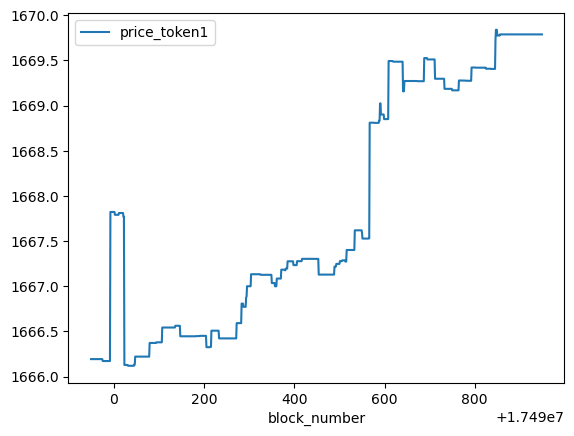

In [16]:
import pandas as pd

df_clean = (df
            .drop_duplicates(subset=['block_number'], keep='last')
            .loc[:, ['block_number', 'evt_reserve0', 'evt_reserve1']]
            .rename(columns={'evt_reserve0': 'reserve0', 'evt_reserve1': 'reserve1'})
            .assign(block_number=lambda x: x.block_number.astype(int),
                    reserve0=lambda x: x.reserve0.apply(int),
                    reserve1=lambda x: x.reserve1.apply(int),))

df_clean['price_token1'] = token0.scaled(df_clean['reserve0']) / token1.scaled(df_clean['reserve1'])
df_clean['price_token0'] = 1 / df_clean['price_token1']

df_clean = (df_clean
            .merge(pd.DataFrame({'block_number': range(context.block_number-1000, context.block_number+1)}), how='right')
            .sort_values('block_number')
            .fillna(method='ffill')
            .fillna(method='bfill'))

display(df_clean)

df_clean.plot('block_number', 'price_token1')

## Summary

What we have go through in CMF

- Initialize context in cmf
- Token: create it from address: query attributes, name, symbol, decimals, etc.
- Contract: create it from address, make web3 call.
- Write a model with web3 call
- Query ledger DB to get decoded event log
- Post-process the data in DataFrame
